In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
GPU=True

if GPU:

    device_name = tf.test.gpu_device_name()

    if device_name != '/device:GPU:0':

        raise SystemError('GPU device not found')

    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Dataset Name:** A Large Scale Fish Dataset

Link: https://www.kaggle.com/crowww/a-large-scale-fish-dataset

## Download the Dataset

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/crowww/a-large-scale-fish-dataset'
od.download(dataset_url)

100%|██████████| 3.24G/3.24G [01:36<00:00, 36.0MB/s]


In [6]:
dataset_path = Path(r'/content/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

file_path = list(dataset_path.glob(r'**/*.png'))

In [7]:
# create labels from the folder name
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [8]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

,image,label
0,/content/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet
1,/content/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet
2,/content/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet
3,/content/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet
4,/content/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet


## Display the images

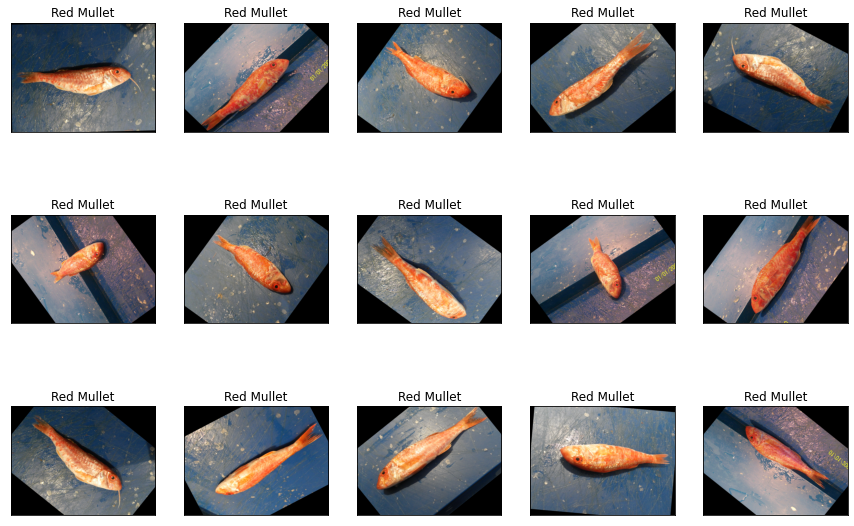

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [10]:
df.label.value_counts()

Shrimp                   1000
Sea Bass GT              1000
Striped Red Mullet       1000
Black Sea Sprat GT       1000
Trout                    1000
Striped Red Mullet GT    1000
Hourse Mackerel          1000
Red Sea Bream            1000
Gilt-Head Bream          1000
Shrimp GT                1000
Sea Bass                 1000
Red Sea Bream GT         1000
Trout GT                 1000
Red Mullet               1000
Red Mullet GT            1000
Hourse Mackerel GT       1000
Black Sea Sprat          1000
Gilt-Head Bream GT       1000
Name: label, dtype: int64

In [11]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Sea Bass              1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Hourse Mackerel       1000
Trout                 1000
Black Sea Sprat       1000
Red Mullet            1000
Striped Red Mullet    1000
Name: label, dtype: int64

In [12]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [13]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5040, 2)
Shape of test data (2700, 2)
Shape of validation data (1260, 2)


In [14]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

In [15]:
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 5040 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.


In [34]:
input_shape = (200, 200, 3)

In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 99, 99, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 23, 23, 32)      

In [37]:
model.compile(optimizer="adam", 
              loss='categorical_crossentropy', 
              metrics=["accuracy"])

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

In [39]:
history = model.fit(train, 
                    validation_data=val, 
                    epochs=30, 
                    callbacks=callback)

Epoch 1/30
158/158 [==============================] - 124s 769ms/step - loss: 2.0907 - accuracy: 0.1694 - val_loss: 1.9642 - val_accuracy: 0.2111
Epoch 2/30
158/158 [==============================] - 121s 769ms/step - loss: 1.8289 - accuracy: 0.2629 - val_loss: 1.6636 - val_accuracy: 0.3468
Epoch 3/30
158/158 [==============================] - 122s 770ms/step - loss: 1.6152 - accuracy: 0.3478 - val_loss: 1.3431 - val_accuracy: 0.4476
Epoch 4/30
158/158 [==============================] - 122s 775ms/step - loss: 1.2406 - accuracy: 0.4899 - val_loss: 1.1452 - val_accuracy: 0.5349
Epoch 5/30
158/158 [==============================] - 123s 779ms/step - loss: 1.0831 - accuracy: 0.5659 - val_loss: 0.9305 - val_accuracy: 0.5937
Epoch 6/30
158/158 [==============================] - 121s 765ms/step - loss: 0.9627 - accuracy: 0.6127 - val_loss: 0.8349 - val_accuracy: 0.6730
Epoch 7/30
158/158 [==============================] - 122s 772ms/step - loss: 0.8596 - accuracy: 0.6607 - val_loss: 0.8102 -

In [40]:
model.save('model-1.h5')

In [41]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

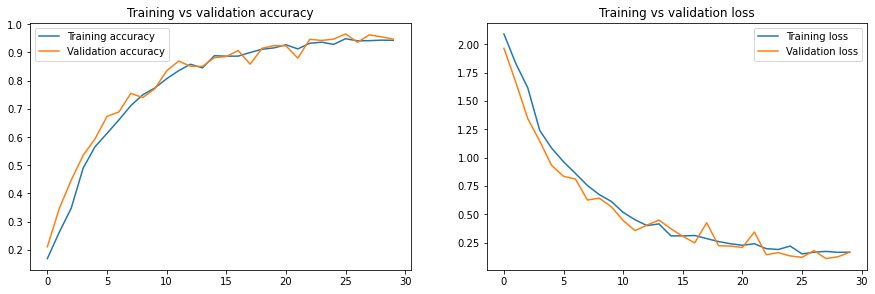

In [42]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [43]:
results = model.evaluate(test)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

85/85 [==============================] - 55s 647ms/step - loss: 0.1163 - accuracy: 0.9585
Test Loss: 0.11626
Test Accuracy: 95.85%


In [44]:
pred = model.predict(test)

In [45]:
pred = np.argmax(pred, axis=1)

In [46]:
labels = train.class_indices

In [47]:
labels

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [48]:
labels = dict((v,k) for k, v in labels.items())

In [49]:
labels

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [50]:
y_pred = [labels[k] for k in pred]

In [51]:
print(classification_report(x_test.label, y_pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.93      1.00      0.96       293
   Gilt-Head Bream       0.85      0.88      0.87       290
   Hourse Mackerel       0.98      0.96      0.97       314
        Red Mullet       0.98      1.00      0.99       305
     Red Sea Bream       0.98      0.87      0.92       301
          Sea Bass       0.89      0.93      0.91       298
            Shrimp       1.00      1.00      1.00       321
Striped Red Mullet       0.98      0.96      0.97       287
             Trout       0.98      0.98      0.98       291

          accuracy                           0.95      2700
         macro avg       0.95      0.95      0.95      2700
      weighted avg       0.95      0.95      0.95      2700



In [52]:
print(confusion_matrix(x_test.label, y_pred))

[[292   0   1   0   0   0   0   0   0]
 [  1 256   2   0   4  27   0   0   0]
 [ 11   0 300   0   1   2   0   0   0]
 [  0   0   0 304   0   0   0   1   0]
 [  0  28   2   0 263   2   0   0   6]
 [  5  13   0   0   0 277   0   3   0]
 [  0   0   0   0   0   0 320   1   0]
 [  6   1   0   5   0   0   0 275   0]
 [  0   2   0   0   0   4   0   0 285]]
